In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import time
import datetime

from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
from collections import OrderedDict

from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.datasets import fetch_covtype
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, zero_one_loss,\
                      f1_score, precision_recall_curve, roc_curve, roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay, average_precision_score

from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier
# import warnings
# import matplotlib.cbook
# warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

>***StackingClassifier***

Стек прогнозаторів з остаточним класифікатором для агрегування прогнозів. Це дозволяє використовувати силу кожного з прогнозаторів.

1. на першому етапі кожний прогнозатор першого рівня дає своє значення прогнозу, в загальному випадку відмінне від значень інших прогнозаторів,
2. на другому етапі заключний прогнозатор (blender/mеtа learner) отримує на
вході такі прогнози і виробляє остаточний прогноз.

Навчальний набір розбивається на два піднабори:
1. Перший - для навчання прогнозаторів першого рівня.
2. Прогнозатори першого рівня виконують прогнозування на другому (hold-out) піднаборі, і виробляються прогнози першого рівня. 
3. Далі створюється новий навчальний набір, використовуючи прогнози
першого рівня в якості вхідних ознак і зберігаючи значення цільової змінної.
Змішувач навчається на цьому новому навчальному наборі,
навчається прогнозувати цільові значення на основі прогнозів
першого рівня.

>***GradientBoostingClassifier***

Алгоритм бустинга на основі дерев рішень, послідовно додає прогнозатори до ансамблю, причому кожний класифікатор коригує свого попередника. Налаштовує новий прогнозатор на залишкові помилки (residual errors), допущені попереднім прогнозатором. Прогноз на новому прикладі знаходять як суму прогнозів за всіма моделями.


>MLPClassifier

Багатошарова нейронна мережа-класифікатор.

Ця модель оптимізує функцію логарифмічних втрат за допомогою LBFGS або стохастичного градієнтного спуску, доступні різні функції активації: {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}


In [ ]:
'''для даних метрик накраще значення 1, найгірше 0'''
# Точність(precision):  tp / (tp + fp)
# Повнота(recall):  tp / (tp + fn)
# F1: 2 * (precision * recall) / (precision + recall)

'''Матриця неточностей (confusion matrix)'''
# кожен рядок відповідає певному класу

def multiclass_metrics(test, pred):
  print("Accuracy:", round(accuracy_score(test, pred),3))
  print("Precision:", [round(i, 3) for i in precision_score(test, pred, average=None)])
  print("Recall:", [round(i, 3) for i in recall_score(test, pred, average=None)])
  print("F1:", [round(i, 3) for i in f1_score(test, pred, average=None)])
  plt.figure(figsize = (7,5))
  print("Confusion matrix:")
  sns.heatmap(confusion_matrix(test, pred), square=True, annot=True)

In [ ]:
def plotPR(X, y, model):
  Y = label_binarize(y, classes=[1, 2, 3, 4, 5, 6, 7])
  n_classes = Y.shape[1]
  X_train, X_test, Y_train, Y_test = train_test_split(
      X, Y, test_size=0.3, random_state=42
  )

  classifier = OneVsRestClassifier(
      make_pipeline(StandardScaler(), model)
  )
  classifier.fit(X_train, Y_train)
  y_score = classifier.predict_proba(X_test)

  precision = dict()
  recall = dict()
  average_precision = dict()
  for i in range(n_classes):
      precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
      average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

  # A "micro-average": quantifying score on all classes jointly
  precision["micro"], recall["micro"], _ = precision_recall_curve(
      Y_test.ravel(), y_score.ravel()
  )
  average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

  import matplotlib.pyplot as plt
  from itertools import cycle

  # setup plot details
  colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

  _, ax = plt.subplots(figsize=(7, 8))

  f_scores = np.linspace(0.2, 0.8, num=4)
  lines, labels = [], []
  for f_score in f_scores:
      x = np.linspace(0.01, 1)
      y = f_score * x / (2 * x - f_score)
      (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
      plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

  display = PrecisionRecallDisplay(
      recall=recall["micro"],
      precision=precision["micro"],
      average_precision=average_precision["micro"],
  )
  display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

  for i, color in zip(range(n_classes), colors):
      display = PrecisionRecallDisplay(
          recall=recall[i],
          precision=precision[i],
          average_precision=average_precision[i],
      )
      display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

  # add the legend for the iso-f1 curves
  handles, labels = display.ax_.get_legend_handles_labels()
  handles.extend([l])
  labels.extend(["iso-f1 curves"])
  # set the legend and the axes
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.legend(handles=handles, labels=labels, loc="best")
  ax.set_title("Extension of Precision-Recall curve to multi-class")
  plt.show()

In [ ]:
def decision_boundaries(X, y, model):
  '''
  границя рішень на основі зменшення розмірності даних до 2D та параметру-моделі
  '''
  X_PCA = PCA(n_components=2).fit_transform(X, y)

  X_train_PCA, X_test_PCA, y_train, y_test = train_test_split(X_PCA, y, train_size=0.995, random_state=42)
  scaler = StandardScaler()
  X_train_PCA = scaler.fit_transform(X_train_PCA)
  X_test_PCA = scaler.transform(X_test_PCA)

  pca_model = model.fit(X_train_PCA, y_train)
  plot_decision_regions(X_test_PCA, y_test, markers='.', clf=pca_model, legend=False)
  plt.title("Decision boundaries")
  plt.show()

In [ ]:
Xf, yf = fetch_covtype(return_X_y=True)

Масив даних розмірністю (581012, 54) та масив ознак розмірністю (581012,).
Кожне значення відповідає одному з 7 типів лісового покриву зі значеннями в діапазоні від 1 до 7.

Проаналізуємо дані за допомогою статистики, створивши датафрейм з масиву прикладів

In [ ]:
# Бачимо, що датасет не збалансований
unique, counts = np.unique(yf, return_counts=True)
print(np.asarray((unique, counts)).T)
df_describe = pd.DataFrame(Xf)
df_describe.describe()
# df_describe.info()
# Xf[:1]

[[     1 211840]
 [     2 283301]
 [     3  35754]
 [     4   2747]
 [     5   9493]
 [     6  17367]
 [     7  20510]]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,0.448865,0.051434,0.436074,0.063627,0.005217,0.012952,0.008301,0.021335,0.002749,0.011316,0.000181,0.000308,0.001974,0.056168,0.021359,0.051584,0.030001,0.001031,0.000005,0.004897,0.005890,0.003268,0.006921,0.015936,0.001442,0.057439,0.099399,0.036622,0.000816,0.004456,0.001869,0.001628,0.198356,0.051927,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,0.497379,0.220882,0.495897,0.244087,0.072039,0.113066,0.090731,0.144499,0.052356,0.105775,0.013442,0.017550,0.044387,0.230245,0.144579,0.221186,0.170590,0.032092,0.002272,0.069804,0.076518,0.057077,0.082902,0.125228,0.037950,0.232681,0.299197,0.187833,0.028551,0.066605,0.043193,0.040318,0.398762,0.221879,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.000000,360.000000,66.000000,1397

In [ ]:
# видаляємо з датасету по 100000 прикладів і ознак, що належать до 1 і 2 надвеликих класів
del1 = np.random.choice(np.where(yf == 1)[0].tolist(), size=150000, replace=False)
X = np.delete(Xf, del1, axis=0)
y = np.delete(yf, del1)
del2 = np.random.choice(np.where(y == 2)[0].tolist(), size=200000, replace=False)
X = np.delete(X, del2, axis=0)
y = np.delete(y, del2)
X.shape[0]

# альтернативно: видаляємо рандомно частину даних
# X, _, y, _ = train_test_split(X, y, test_size=0.3, random_state=42)

# розбиваємо датасет на 3 вибірки
# навчальну, валідаційну й тестову
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.5, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

In [ ]:
pipe = Pipeline([("scaler", StandardScaler()), 
                 ("mlp", MLPClassifier(hidden_layer_sizes=(200,),max_iter=400,
                                       solver='sgd', warm_start=True, early_stopping=True))])

param_grid = {'mlp__learning_rate_init': [0.01, 0.1],
              'mlp__activation': ['tanh', 'relu']}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=3)
grid.fit(X_train, y_train)
print("Найкраще значення перехресної перевірки:{:.2f}".format(grid.best_score_))
print("Правильність на валідаційному наборі: {:.2f}".format(grid.score(X_valid, y_valid)))
print("Найкращі параметри: {}".format(grid.best_params_))

>solver='adam' та 'sgd' при окремих запусках GridSearchCV дали однаковий результат, але 'adam' швидший

Найкраще значення перехресної перевірки:0.86

Правильність на валідаційному наборі: 0.87

Найкращі параметри: {'mlp__activation': 'tanh', 'mlp__learning_rate_init': 0.01}

In [ ]:
# Дані треба обробити, тут їх масштабуємо та центруємо
# тобто приводимо до нульового середнього та одиничної дисперсiї

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Обравши кращу модель, навчаємо її та обчислюємо
1. значення функції втрат на перших і останніх ітераціях
2. час навчання моделі
3. метрики та криві presision-recall для класів

Time of learning: 0:02:42.295000 
Loss function, first 5 iters: [0.686, 0.552, 0.493, 0.462, 0.437]
Loss function, last 5 iters: [0.314, 0.311, 0.312, 0.311, 0.312]
Training set score:  0.884
Test set score:  0.866
Accuracy: 0.866
Precision: [0.863, 0.865, 0.873, 0.861, 0.785, 0.799, 0.965]
Recall: [0.832, 0.877, 0.914, 0.664, 0.848, 0.808, 0.921]
F1: [0.847, 0.871, 0.893, 0.75, 0.815, 0.804, 0.942]
Confusion matrix:


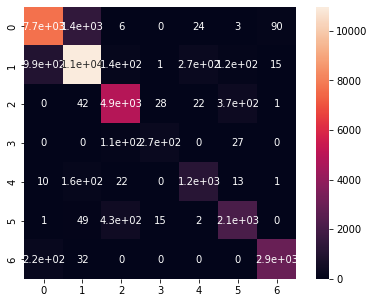

In [ ]:
start_time = time.time()

neuralclf = MLPClassifier(hidden_layer_sizes=(200,),max_iter=400,
                          solver='adam', activation='tanh', learning_rate_init=0.01,
                          early_stopping=True).fit(X_train, y_train)

sec = round(time.time() - start_time, 3)
print("Time of learning:", str(datetime.timedelta(seconds=sec)))

print("Loss function, first 5 iters:", [round(i, 3) for i in neuralclf.loss_curve_[:5]])
print("Loss function, last 5 iters:", [round(i, 3) for i in neuralclf.loss_curve_[-5:]])

# ці метрики вбудовані в методи класу, для мультикласової класифікації вони грубі
print("Training set score: ", round(neuralclf.score(X_train, y_train), 3))
print("Test set score: ", round(neuralclf.score(X_test, y_test), 3))

y_pred = neuralclf.predict(X_test)
multiclass_metrics(y_test, y_pred)

Можемо побачити, що на тестовій вибірці значення дещо гірші. Можна подолати це за допомогою регуляризації.

Також крива PR показує, що не всі класи однаково гарно прогнозуються.


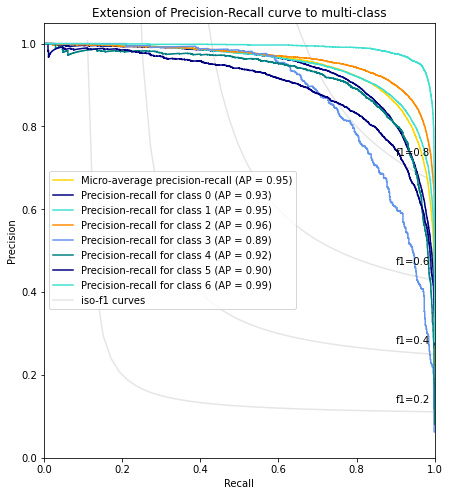

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(200,),max_iter=400,
                          solver='adam', activation='tanh', learning_rate_init=0.01,
                          early_stopping=True)
plotPR(X, y, clf)

В нашому випадку границі рішень є поганою візуалізацією роботи алгоритму, бо зменшення розмірності псує наочність

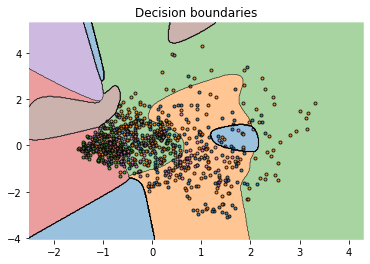

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(200,),max_iter=400,
                          solver='adam', activation='tanh', learning_rate_init=0.01,
                          early_stopping=True)

decision_boundaries(X_train, y_train, clf)

Створимо ансамбль моделей на основі стекінгу та бегінгу, використаємо MLPClassifier та моделі SVC(kernel='poly'), LinearSVC які в минулій лабораторній показала гірші результати, ніж нейронна мережа.

Розглянемо StackingClassifier та рiзнi значення:
1. final_estimator - остаточний класифікатор
2. stack_method:{‘auto’, ‘predict_proba’, ‘decision_function’, ‘predict’}

Але спочатку подивимося, що ансамбль дає кращий результат, якщо взяти за базові прогнозатори MLPClassifier та LinearSVC.

Time of learning: 0:24:21.395000
Training set score:  0.883
Test set score:  0.87
Accuracy: 0.87
Precision: [0.874, 0.876, 0.912, 0.62, 0.751, 0.817, 0.925]
Recall: [0.832, 0.869, 0.885, 0.932, 0.888, 0.84, 0.966]
F1: [0.852, 0.873, 0.898, 0.744, 0.814, 0.828, 0.945]
Confusion matrix:


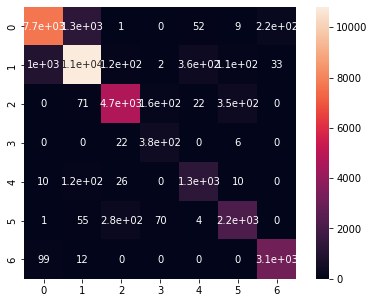

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

start_time = time.time()

estimators = [
    ('mlp', MLPClassifier(hidden_layer_sizes=(200,),max_iter=400,
                          solver='adam', activation='tanh', learning_rate_init=0.01,
                          early_stopping=True)),
    ('svr', LinearSVC(C=100, max_iter=10000, dual=False, class_weight='balanced', random_state=42))
]
stackclf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(solver='sag', class_weight='balanced', max_iter=300, warm_start=True)
).fit(X_train, y_train)
sec = round(time.time() - start_time, 3)
print("Time of learning:", str(datetime.timedelta(seconds=sec)))


print("Training set score: ", round(stackclf.score(X_train, y_train), 3))
print("Test set score: ", round(stackclf.score(X_test, y_test), 3))

y_pred = stackclf.predict(X_test)
multiclass_metrics(y_test, y_pred)


На даному датасеті метод опорних векторів працює дуже повільно, хоча модель з поліноміальним ядром мала б дати кращий результат ніж LinearSVC, GridSearchCV показав гірші результати, ніж неансамблевий прогноз.

In [ ]:
m = MLPClassifier(hidden_layer_sizes=(200,),max_iter=400,
                          solver='adam', activation='tanh', learning_rate_init=0.01,
                          early_stopping=True, warm_start=True)

stack_clf = StackingClassifier(
    estimators=[
    ('mlp', make_pipeline(StandardScaler(),
                          m)),
    ('svm', make_pipeline(StandardScaler(),
                          SVC(kernel='poly', C=1000, degree=4, class_weight='balanced')))]
)

param_grid = {'final_estimator': [LogisticRegression(solver='sag', class_weight='balanced', max_iter=300, warm_start=True), m],
              'stack_method': ['auto', 'predict_proba']}
grid = GridSearchCV(stack_clf, param_grid=param_grid, cv=3)
grid.fit(X_valid, y_valid)
print("Найкраще значення перехресної перевірки:{:.2f}".format(grid.best_score_))
print("Правильність на тестовому наборі: {:.2f}".format(grid.score(X_test, y_test)))
print("Найкращі параметри: {}".format(grid.best_params_))

Найкраще значення перехресної перевірки:0.82

Правильність на тестовому наборі: 0.84

Найкращі параметри: {'final_estimator': MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=(200,),
              learning_rate_init=0.01, max_iter=400, warm_start=True), 'stack_method': 'auto'}

Отже, оскільки в першому ансамблі ми отримали непоганий результат, але score вище на навчальній вибірці (це перенавчання), тож спробуємо тепер додати регуляризацію до нейронної мережі (збільшити параметр alpha) та зробити її остаточним прогнозатором.

Time of learning: 0:20:58.196000
Training set score:  0.857
Test set score:  0.847
Accuracy: 0.847
Precision: [0.865, 0.834, 0.843, 0.836, 0.735, 0.822, 0.935]
Recall: [0.787, 0.876, 0.925, 0.709, 0.799, 0.704, 0.938]
F1: [0.824, 0.855, 0.882, 0.767, 0.766, 0.758, 0.937]
Confusion matrix:


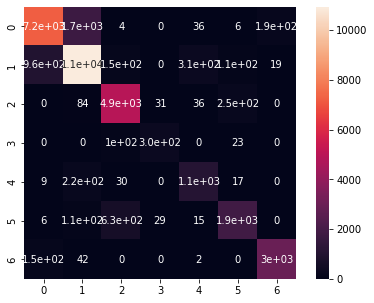

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

start_time = time.time()

estimators = [
    ('mlp', MLPClassifier(hidden_layer_sizes=(200,),max_iter=400, alpha=0.01,
                          solver='adam', activation='tanh', learning_rate_init=0.01,
                          early_stopping=True)),
    ('svr', LinearSVC(C=100, max_iter=10000, dual=False, class_weight='balanced', random_state=42))
]
stackclf = StackingClassifier(
    estimators=estimators, 
    final_estimator= MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=(200,), solver='adam', alpha=0.01,
                                  learning_rate_init=0.01, max_iter=400)
    ).fit(X_train, y_train)
sec = round(time.time() - start_time, 3)
print("Time of learning:", str(datetime.timedelta(seconds=sec)))


print("Training set score: ", round(stackclf.score(X_train, y_train), 3))
print("Test set score: ", round(stackclf.score(X_test, y_test), 3))

y_pred = stackclf.predict(X_test)
multiclass_metrics(y_test, y_pred)

Виміряно час навчання окремих моделей та стекінгового ансамблю, другий є значно довшим.

Теперь розглянемо GradientBoostingClassifier. Він дає кращі результати, ніж попередній ансамбль, та працює за принципом навчання багатьох слабких учнів. Але тут також є перенавчання, то треба додати регуляризацію або ваги до класів, оскільки має місце незбалансованість.

Training set score:  0.978
Test set score:  0.912
Accuracy: 0.912
Precision: [0.914, 0.9, 0.929, 0.806, 0.862, 0.898, 0.966]
Recall: [0.885, 0.922, 0.948, 0.754, 0.822, 0.891, 0.965]
F1: [0.899, 0.911, 0.938, 0.779, 0.841, 0.894, 0.966]
Confusion matrix:


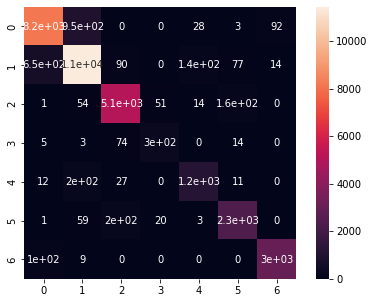

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

treeclf = GradientBoostingClassifier(
      n_estimators=1000, learning_rate=0.5, max_depth=10, 
      random_state=42, validation_fraction=0.2, n_iter_no_change=10, tol=0.01,
      ).fit(X_train, y_train)

print("Training set score: ", round(treeclf.score(X_train, y_train), 3))
print("Test set score: ", round(treeclf.score(X_test, y_test), 3))

y_pred = treeclf.predict(X_test)
multiclass_metrics(y_test, y_pred)

Побудова графiків залежностi значень мiри якостi вiд значення n_estimators для ансамблiв показує однакові значення помилки, це може бути пояснено тим, що параметр max_depth в даному випадку грає більшу роль (при max_depth=3 оцінка була значно нижча).

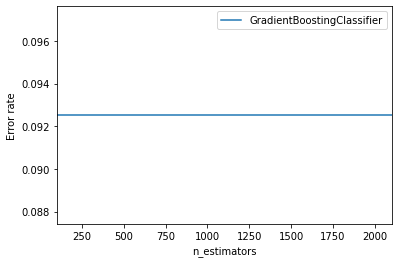

In [ ]:
ensemble_clfs = [
    (
        "GradientBoostingClassifier",
        GradientBoostingClassifier(
        learning_rate=0.1, max_depth=10, 
        random_state=42, validation_fraction=0.2, n_iter_no_change=5, tol=0.01,
      ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 2100

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 500):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the error for each `n_estimators=i` setting.
        # err = zero_one_loss(clf.predict(X_test), y_test) 
        err = f1_score(y_test, clf.predict(X_test), average=None)
        error_rate[label].append((i, err))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Error rate")
plt.legend(loc="upper right")
plt.show()

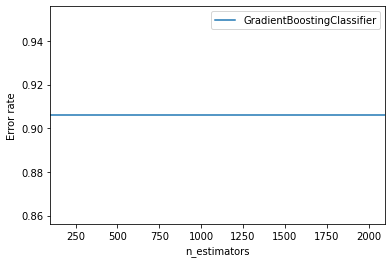

In [ ]:
ensemble_clfs = [
    (
        "GradientBoostingClassifier",
        GradientBoostingClassifier(
        learning_rate=0.1, max_depth=10, 
        random_state=42, validation_fraction=0.2, n_iter_no_change=5, tol=0.01,
      ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 2100

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 500):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the error for each `n_estimators=i` setting.
        # err = zero_one_loss(clf.predict(X_test), y_test) 
        err = f1_score(y_test, clf.predict(X_test), average='weighted')
        error_rate[label].append((i, err))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Error rate")
plt.legend(loc="upper right")
plt.show()